In [1]:
import matplotlib.pylab as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from IPython import display

%config InlineBackend.figure_format='retina'
# %matplotlib notebook

# Point cloud alignment and SVD

## Singular value decomposition

Recently I studied the problem of finding the rotation and translation between two point sets and decided to write the post about it. The key here is *singular value decomposition*, or SVD.

It is extremely popular technique in many types of linear problems. It should be not surprised, that the point cloud alignment problem can be solved with its help. 
My aim here is to show all accommpanying theory and provide the point cloud alignment algorithm that takes not more than 10 lines of code in Python.

I would like to start from SVD.
It is convinient to think about any matrix as a function, action, or transformation $A$, that maps points $\vec{x} \in R^n$ to points $\vec{y} = A\vec{x} \in R^m$. Intuitively, we can raise the question: what happens to the geometry of $R^n$ after action $A$. If our initial column space $R^n$ is represented by orthonormal basis, that can be visualzed as a grid, then we ask the following questions: what happens with our grid's *squares* after transformation $A$.

Let's illustrate this problem with simple graphics.

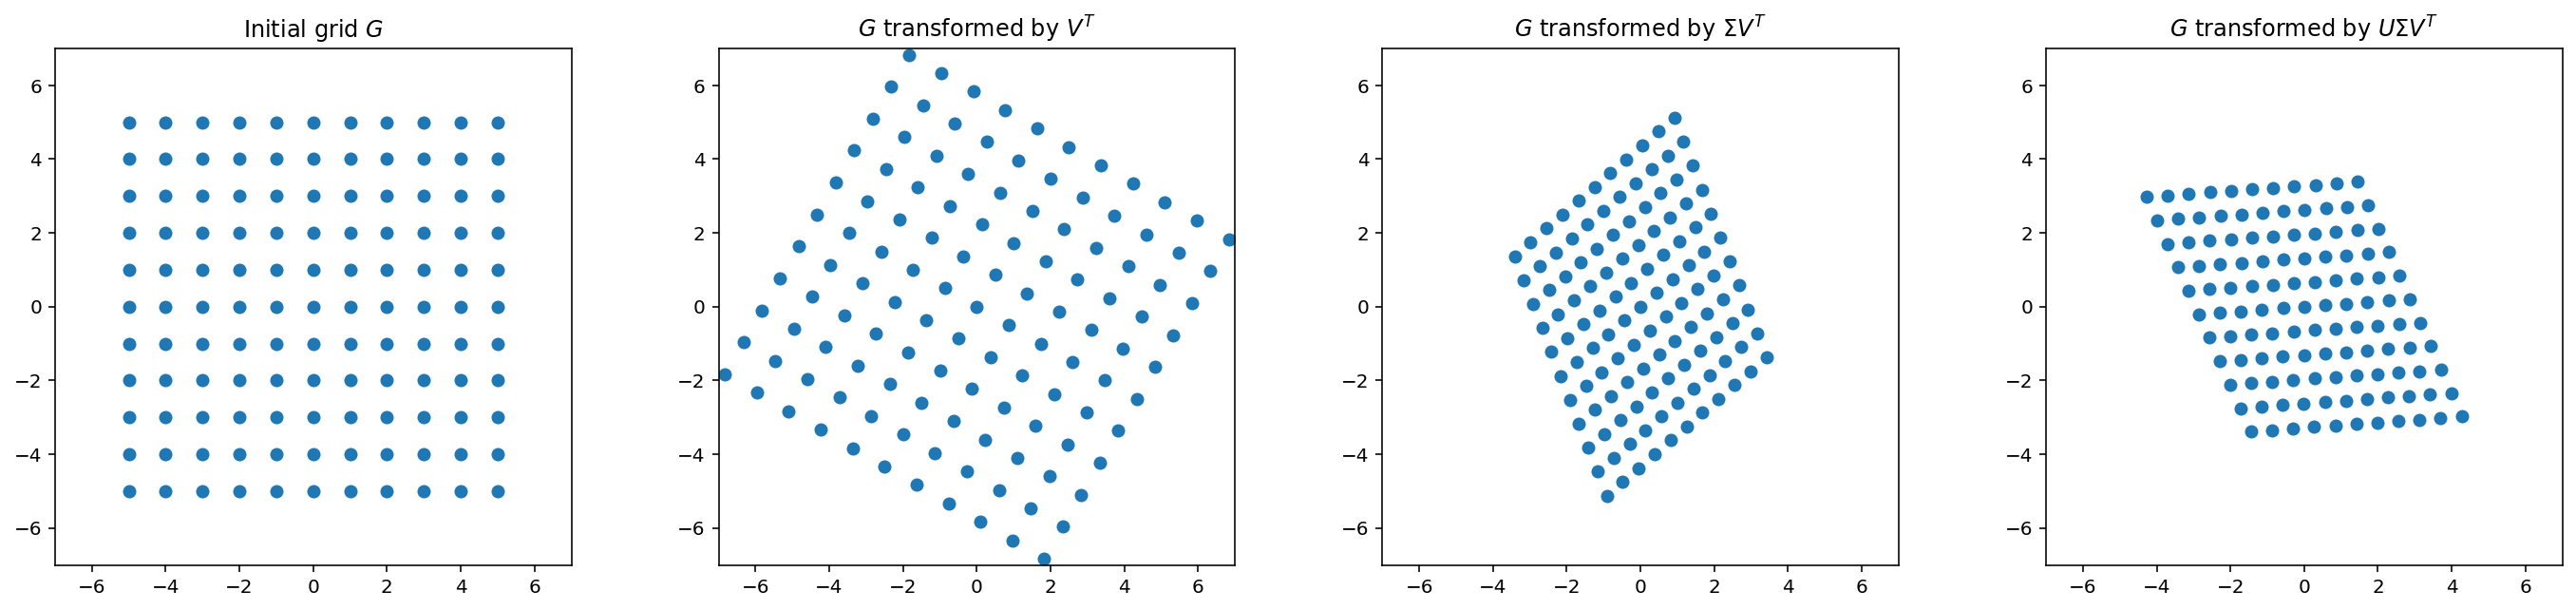

In [2]:
def genRMatrix(theta):
    return np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

def transform(A, X, Y):
    mult = A @ np.array([X.ravel(), Y.ravel()])
    return mult[0,:].reshape(X.shape), mult[1,:].reshape(Y.shape)

def visualise(ax, X, Y, title):
    ax.scatter(X, Y)
    ax.axis("equal")
    ax.set_xlim(-7, 7)
    ax.set_ylim(-7, 7)
    ax.set(adjustable='box', aspect='equal')
    ax.set_title(title)

x = np.linspace(-5, 5, 11)
y = np.linspace(-5, 5, 11)
X, Y = np.meshgrid(x, y, sparse=False)
fig, ax = plt.subplots(1, 4, figsize = (24, 5), subplot_kw=dict(aspect='equal'), 
                       gridspec_kw=dict(width_ratios=[1,1,1,1]))
visualise(ax[0], X, Y, "Initial grid $G$")

alphaV = np.deg2rad(30)
VT = genRMatrix(alphaV).T
XVT, YVT = transform(VT, X, Y)
visualise(ax[1], XVT, YVT, "$G$ transformed by $V^T$")

S = np.array([[0.5, 0], [0, 0.75]])
XSVT, YSVT = transform(S @ VT, XVT, YVT)
visualise(ax[2], XSVT, YSVT, "$G$ transformed by $\Sigma V^T$")

alphaU = np.deg2rad(45)
U = genRMatrix(alphaU)
A = USVT = U @ S @ VT
XUSVT, YUSVT = transform(A, X, Y)
visualise(ax[3], XUSVT, YUSVT, "$G$ transformed by $U \Sigma V^T$")

The SVD is very helpful because it is always exists for any matrix $A \in R^{m \times n}$. From geometric standpoint the SVD can be seen as a composition of isometry, followed by a scale in each coordinate axis and a second isometry. The isometry means that $U$ and $V$ are orthogonal: their action preserves lengths and the angles.

Let's solve the reverse problem: find the SVD factorization for our matrix $A$:

In [3]:
u, s, v = np.linalg.svd(A)
print("U:\n", u)
print("S:\n", s)
print("V:\n", v)

U:
 [[-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]
S:
 [0.75 0.5 ]
V:
 [[-0.5        0.8660254]
 [ 0.8660254  0.5      ]]


We can note that the order is different. It happens because usually the math libraries return left and singular vectors $U$ and $V$, and the corresponding singular values in sorted order, such as $\sigma_1 \geq \sigma_2 \geq \dots \sigma_n \geq 0$.

### SVD computation
It is valuable to note why SVD computation is costly:
* The columns of $V$ are the eigenvectors of $A^T A$ (that can be computed, by example, using QR iteration).
* Then, rewriting $A = U \Sigma V^T$ as $AV = U \Sigma$ we can make the observation that the columns of $U$ corresponding to $\sigma_i \neq 0$ are normalized columns of $AV$.
* The remaining columns satisfy the following property: $AA^T\vec{u}_i = 0$. They can be computed through LU factorization.

## Point cloud alignment, the Procrustes problem

The problem of the shape alignment arises quite often in computer vision problems. For example, we can have the lidar scan results that consist of two point clouds of the same object from different views. A task here is to align these points, or to find the rotation matrix $R$ and translation $\vec{t}$ that align one point set to another. It is assumed that the points correspondences are known (in our case - the corresponding points have the same indices).

Mathematically, this problem can be formulated in the following way:
* Having $n$ overlapping points from two point clouds we can store them in two matrices $X_1, X_2 \in R^{m \times n}$, where $m$ is the number of degrees of freedom of the point.
* Then, for each point $\vec{x}_{1i}$ of $X_1$ and $\vec{x}_{2i}$ of $X_2$ the following equality should hold:
$$R \vec{x}_{1i} + \vec{t} = \vec{x}_{2i}$$
* Because of the errors, the following energy function should be minimized:
$$E(R, \vec{t}) = \sum_i || R \vec{x}_{1i} + \vec{t} - \vec{x}_{2i}||^2$$.
* The minimum of the objective function can be found by taking the derivative w.r.t. $R$ and $\vec{t}$.

## Translational component

To find the optimal $\vec{t}$ value we have to fix $R$ and find the derivative w.r.t. $\vec{t}$:
$$
\begin{array}{c}
\sum_i || R \vec{x}_{1i} + \vec{t} - \vec{x}_{2i}||^2 = \\\
= \sum_i (R \vec{x}_{1i} + \vec{t} - \vec{x}_{2i}) \cdot (R \vec{x}_{1i} + \vec{t} - \vec{x}_{2i}) = \\\
= \sum_i (R \vec{x}_{1i} + \vec{t} - \vec{x}_{2i})^T (R \vec{x}_{1i} + \vec{t} - \vec{x}_{2i}) = \\\
= \sum_i (\vec{x}_{2i}^T R^T R \vec{x}_{1i} + \vec{x}_{1i}^T R^T \vec{t} - \vec{x}_{1i}^T R^T \vec{x}_{2i} + \vec{t} R \vec{x}_{1i} + \vec{t}^T \vec{t} - \vec{t} \vec{x}_{2i} - \vec{2}_{1i}^T R \vec{x}_{1i} - \vec{x}_{2i}^T \vec{t} + \vec{x}_{2i}^T \vec{x}_{2i})
\end{array}
$$
The gradient of this expression w.r.t. $\vec{t}$ must be zero at the minimum, therefore, dropping out the terms, do not depending on $\vec{t}$ we have:
$$
\begin{array}{c}
\frac{\delta E}{\delta \vec{t}} = \frac{\delta}{\delta \vec{t}}\sum_{i} (2 \vec{t}^T R \vec{x}_{1i} - 2 \vec{t}^T \vec{x}_{2i} + \vec{t}^T \vec{t}) = \\\
= \sum_{i} (2 R \vec{x}_{1i} - 2 \vec{x}_{2i} + 2 \vec{t}) = \\\
= 2 n\vec{t} + \sum_{i}(2 R \vec{x}_{1i} - 2\vec{x}_{2i}) = \\\
= n\vec{t} + \sum_{i}(R \vec{x}_{1i} - \vec{x}_{2i})
\end{array}
$$
Setting to zero at critical point:
$$
\begin{array}{c}
n\vec{t} + \sum_{i}(R \vec{x}_{1i} - \vec{x}_{2i}) = 0 \\\
n\vec{t} = \sum_{i}(\vec{x}_{2i} - R \vec{x}_{1i}) \\\
n\vec{t} = \sum_{i}(\vec{x}_{2i} - R \vec{x}_{1i}) \\\
\vec{t} = \frac{\sum_{i}(\vec{x}_{2i} - R \vec{x}_{1i})}{n}
\end{array}
$$

## Rotational component

To find the optimal $R$ we have to fix $\vec{t}$ and find the $R$ subject to constraint that $R$ is an orthogonal matrix: $R^T R = I_{3}$. See the detailed description and the derivation of the problem solution [here](https://simonensemble.github.io/2018-10-27-orthogonal-procrustes/).

The orthogonal matrix $R$ minimizing the $||RX - Y||^2$ is given by $V U^T$, where SVD is applied to find out $XY^T = U\Sigma V^T$.

## Alternation

Now, knowing how both the components can be found, one of the most typical strategies is the alternation (that is used in EM algorithm, clustering method and other iterative algorithms):
1. Fix $R$ and minimize $E$ w.r.t. $\vec{t}$.
2. Fix the newly found $\vec{t}$ and minimize $E$ w.r.t. $R$ under $R^T R = I_3$ constraint.
3. Go to step 1 until convergence.

Since in this procedure the $R$ and $\vec{t}$ are not optimized simultaneously, there is no guarantee that we reach the globally optimal solution, but in practice it works well.

## Example

Suppose we have a set of 2d points $X_1$, and let's rotate and translate them randomly, generating point set $X_2$:

In [9]:
# generate points for X1 set
x1part1 = np.array([[0, 0], [4, 4], [4, 0], [0, 4], [2., 6.], [1, 1], [1, 3], [3, 3], [3, 1]]).T
thetas = np.linspace(0, 2 * np.pi, 24)
x1part2 = np.vstack([np.sin(thetas) * 3 + 8, np.cos(thetas) * 3 + 2])
x1part3 = np.vstack([np.sin(thetas) * 4 + 12, np.cos(thetas) * 3 + 4])
X1 = np.hstack([x1part1, x1part2, x1part3])

# randomly pick angle and translation
rotationAngle = np.deg2rad(np.random.randint(-180, 180, 1)[0])
rotation = genRMatrix(rotationAngle)
translation = np.random.randint(-10, 10, 2).reshape((2, 1))

# rotate our original point set X1
X2 = rotation @ X1 + translation

Our alternation step for $R$ and $t$ estimation is defined in `pointCloudAlignmentStep` function, the residual calculation between two point clouds, that is used as termination condition - in `pointCloudResidual` function.

In [10]:
def pointCloudAlignmentStep(R, t, X1, X2):
    foundTransl = np.mean((X2 - R @ X1), axis=1).reshape((2, 1))
    u, s, v = np.linalg.svd(X1 @ (X2 - foundTransl).T)
    foundRot = v @ u.T
    return foundRot, foundTransl

def pointCloudResidual(R, t, X1, X2):
    X2f = R @ X1 + t
    return np.linalg.norm(X2 - X2f)

In [11]:
# initial values
R = np.eye(2)
t = np.zeros((2, 1))
MIN_RESIDUAL_TO_TERMINATE = 1e-8

# find the translation and rotation between two point clouds iteratively
while pointCloudResidual(R, t, X1, X2) > MIN_RESIDUAL_TO_TERMINATE:
    R, t = pointCloudAlignmentStep(R, t, X1, X2)
    
print("True rotation and translation between point sets.\nR:\n", rotation, "\nt:\n", translation)
print("Estimated rotation and translation between point sets.\nR:\n", R, "\nt:\n", t)

True rotation and translation between point sets.
R:
 [[ 0.5591929  -0.82903757]
 [ 0.82903757  0.5591929 ]] 
t:
 [[-10]
 [  1]]
Estimated rotation and translation between point sets.
R:
 [[ 0.5591929  -0.82903757]
 [ 0.82903757  0.5591929 ]] 
t:
 [[-10.]
 [  1.]]


In the end let's visialize the algorithm actions:

In [12]:
from matplotlib import animation

class PointCloudAlignmentAnimation(object):
    def __init__(self, fig, ax, X1, X2):
        self.fig = fig
        self.ax = ax
        
        self.fromScatter = ax.scatter(X1[0, :], X1[1, :], label = "Point set 1")
        self.toScatter = ax.scatter(X2[0, :], X2[1, :], label = "Point set 2")

        plt.tight_layout()
        
        self.R = np.eye(2)
        self.t = np.zeros((2, 1))
        
        self.X1 = X1
        self.X2 = X2
        
        self.ax.axis("equal")
        minX, maxX = np.min([X1[0, :], X2[0, :]]), np.max([X1[0, :], X2[0, :]])
        minY, maxY = np.min([X1[1, :], X2[1, :]]), np.max([X1[1, :], X2[1, :]])
        self.ax.set(xlim = (minX - 2, maxX + 2), ylim = (minY - 2, maxY + 2))
        self.ax.grid()
        self.ax.legend()
        
    def init(self):
        self.fromScatter.set_offsets(np.c_[self.X2[0, :], self.X2[1, :]])
        self.toScatter.set_offsets(np.c_[self.X1[0, :], self.X1[1, :]])
        return (self.fromScatter, self.toScatter, )

    def __call__(self, i):
        X2f = self.R @ self.X1 + self.t
        if i % 2 == 0:
            self.R, self.t = pointCloudAlignmentStep(self.R, self.t, self.X1, self.X2)
        
        self.fromScatter.set_offsets(np.c_[self.X2[0, :], self.X2[1, :]])
        self.toScatter.set_offsets(np.c_[X2f[0, :], X2f[1, :]])
        
        return (self.fromScatter, self.toScatter, )

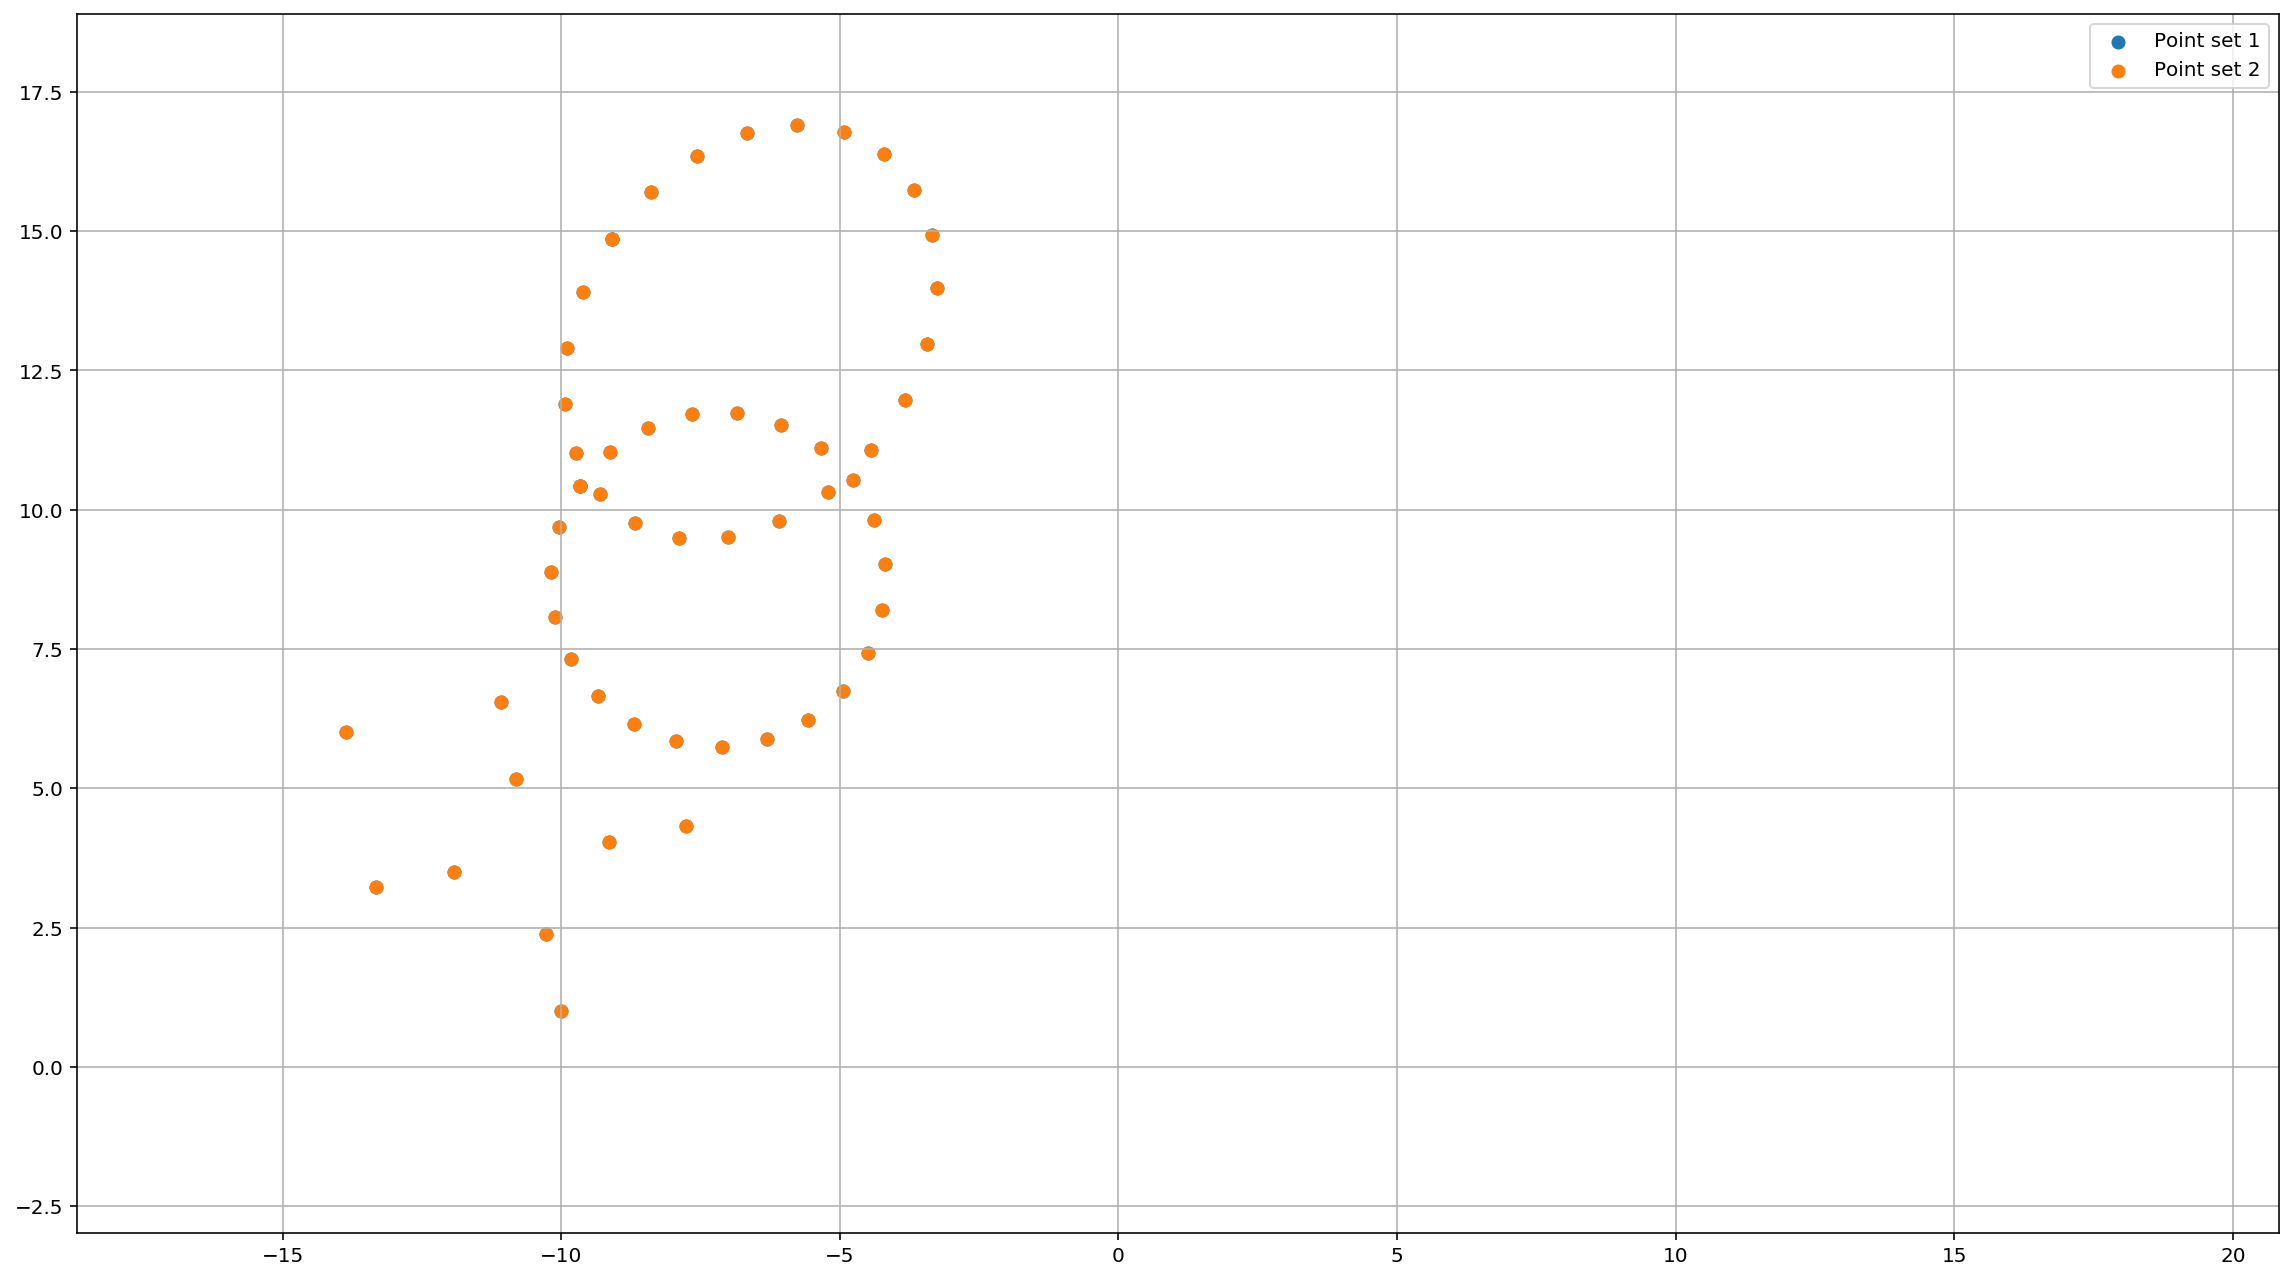

In [14]:
fig, ax = plt.subplots(1, 1, figsize = (16, 9))
pclAnimation = PointCloudAlignmentAnimation(fig, ax, X1, X2)
anim = animation.FuncAnimation(fig, pclAnimation, init_func = pclAnimation.init,
                     frames = 100, interval = 200, blit = True, repeat=False)

plt.rcParams['savefig.dpi'] = 200
plt.rcParams['animation.embed_limit'] = 2**128
FFwriter = animation.FFMpegWriter(fps=30, codec="libx264")     
anim.save('pclAnimation.mp4', writer = FFwriter )

If you are interested in more complex topic or want to find the ready-to-use solution for your problem do not forget to check [Point Cloud Library](https://pointclouds.org/).